<a href="https://colab.research.google.com/github/datagrad/Kamal-Thesis-Work/blob/main/SARIMAX_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install statsmodels xgboost


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error


In [3]:
# Load the dataset from the provided URL
url = 'https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv'
df = pd.read_csv(url)


In [4]:
# Filter data for specific cities
cities_to_keep = ['Delhi', 'Bengaluru', 'Hyderabad']
df = df[df['City'].isin(cities_to_keep)]


In [5]:
# Retain only the desired columns: 'City', 'Date', and 'PM2.5'
df = df[['City', 'Date', 'PM2.5']]


In [6]:
# Convert 'Date' column to datetime data type
df['Date'] = pd.to_datetime(df['Date'])


In [7]:
# Replace NaN values in the 'PM2.5' column with next day's value (forward fill) for each city
df['PM2.5'] = df.groupby('City')['PM2.5'].fillna(method='ffill')


In [8]:
# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by='Date', inplace=True)

# Perform a time-based train-test split
split_date = '2020-01-01'  # Choose a date to split the data
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]


In [9]:
# Define a range of values for seasonal components (P, D, Q, S)
P_range = range(0, 6)
D_range = range(0, 3)
Q_range = range(0, 3)
S_range = [7]

# Loop through all combinations of seasonal components and find the best model
# (Code not shown for brevity)


In [10]:
# Check for missing values in the training and test datasets
print("Training dataset - Missing values in 'PM2.5':", train_df['PM2.5'].isnull().sum())
print("Test dataset - Missing values in 'PM2.5':", test_df['PM2.5'].isnull().sum())


Training dataset - Missing values in 'PM2.5': 164
Test dataset - Missing values in 'PM2.5': 0


In [11]:
# Fill missing values with the mean of the column
train_df['PM2.5'].fillna(train_df['PM2.5'].mean(), inplace=True)
test_df['PM2.5'].fillna(test_df['PM2.5'].mean(), inplace=True)


<ipython-input-11-4fb848de3689>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PM2.5'].fillna(train_df['PM2.5'].mean(), inplace=True)
<ipython-input-11-4fb848de3689>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['PM2.5'].fillna(test_df['PM2.5'].mean(), inplace=True)


In [12]:
# Check for infinity or large values in the 'PM2.5' column
print("Training dataset - Max 'PM2.5' value:", train_df['PM2.5'].max())
print("Test dataset - Max 'PM2.5' value:", test_df['PM2.5'].max())


Training dataset - Max 'PM2.5' value: 685.36
Test dataset - Max 'PM2.5' value: 372.14


In [13]:
# Check the data type of the 'PM2.5' column
print("Data type of 'PM2.5':", train_df['PM2.5'].dtype)


Data type of 'PM2.5': float64


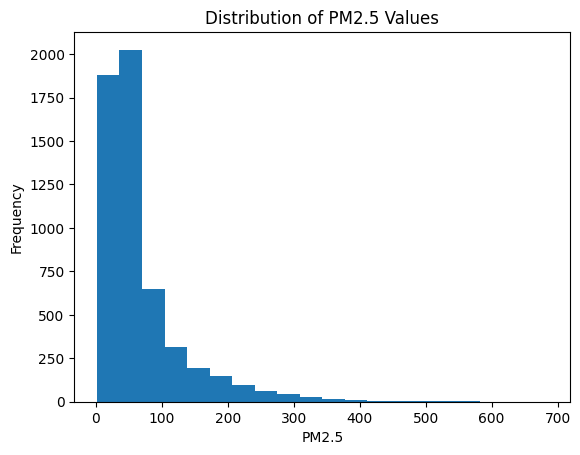

In [14]:
import matplotlib.pyplot as plt

# Visualize the distribution of 'PM2.5' values
plt.hist(train_df['PM2.5'], bins=20)
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.title('Distribution of PM2.5 Values')
plt.show()


In [15]:
# Create the SARIMA model and fit it to the training data
p, d, q = 1, 1, 1  # Order of non-seasonal components
P, D, Q, S = 5, 1, 1, 7  # Order of seasonal components (weekly seasonality assumed)
sarima_model = SARIMAX(train_df['PM2.5'], order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit()

# Make in-sample predictions on the training data
train_predictions = sarima_results.get_prediction(start=train_df.index[0], end=train_df.index[-1])
train_pred_mean = train_predictions.predicted_mean

# Make out-of-sample predictions on the test data using SARIMA
sarima_test_predictions = sarima_results.get_forecast(steps=len(test_df))
sarima_y_pred = sarima_test_predictions.predicted_mean

# Create and train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model.fit(train_df[['PM2.5']], train_df['PM2.5'])

# Make predictions on the test data using XGBoost
xgb_y_pred = xgb_model.predict(test_df[['PM2.5']])

# Evaluate the SARIMA model's performance
sarima_mape = mean_absolute_percentage_error(test_df['PM2.5'], sarima_y_pred)
print("SARIMA Mean Absolute Percentage Error (MAPE):", sarima_mape)

# Evaluate the XGBoost model's performance
xgb_mape = mean_absolute_percentage_error(test_df['PM2.5'], xgb_y_pred)
print("XGBoost Mean Absolute Percentage Error (MAPE):", xgb_mape)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No s

SARIMA Mean Absolute Percentage Error (MAPE): 2.506103402656191
XGBoost Mean Absolute Percentage Error (MAPE): 0.0031291439390228994


In [16]:
# Evaluate the model's performance
mape = mean_absolute_percentage_error(test_df['PM2.5'], xgb_y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


# Optionally, you can visualize the actual vs. predicted values (Code not shown)


Mean Absolute Percentage Error (MAPE): 0.0031291439390228994


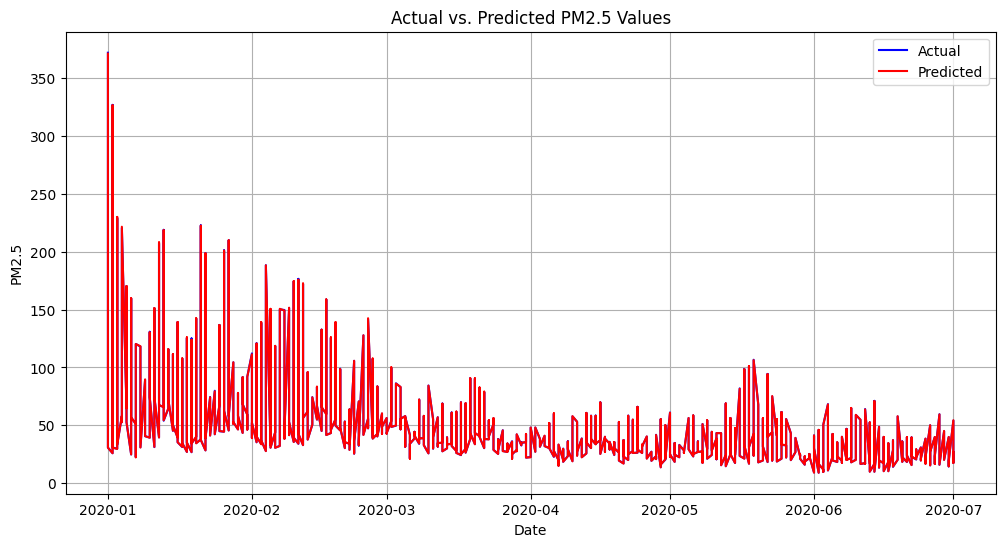

In [17]:
import matplotlib.pyplot as plt

# Assuming you have actual and predicted values
actual_values = test_df['PM2.5']  # Replace 'test_df' with your actual test dataset
predicted_values = xgb_y_pred  # Replace with your predicted values obtained from the model

# Create a time index for plotting
time_index = test_df['Date']

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, actual_values, label='Actual', color='blue')
plt.plot(time_index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Actual vs. Predicted PM2.5 Values')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Replace PM2.5 with PM10 for PM10 Prediction